## Module 4 - In this jupyter notebook, target productivity and productivity gaps are calculated

**Last update: 23-Sept-2024**

[![Open in Colab](https://raw.githubusercontent.com//wateraccounting/WaPORMOOC/main/images/colab-badge.png)](https://colab.research.google.com/github/wateraccounting/WaPORIPA/blob/main/Notebooks_v1.0/Module_4_ProductivityGaps.ipynb?target=\"_blank\")

* Step 1 - Set up
* Step 2 - Calculate the target productivity
* Step 3 - Identify bright spots
* Step 4 - calculate productivity gaps
* Step 5 - Downlaod the results
**=============================================================================================**
![title](https://github.com/wateraccounting/WAPORWP/blob/master/Notebooks/img/Fig5.PNG?raw=true)
**=============================================================================================**

## Step 1 - Set up

## i) Import packages/libraries

In [1]:
!pip install rioxarray --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 8.6 MB/s eta 0:00:00


In [2]:
import os                                               # Provides functions to interact with the operating system
import glob                                             # Used to find file paths matching a specified pattern
import numpy as np                                      # For numerical computations and array manipulation
import pandas as pd                                     # For data manipulation and analysis, especially with DataFrames
from matplotlib.patches import Rectangle                # Allows drawing rectangles in plots, useful for custom legends or highlighting areas
import matplotlib.lines as mlines                       # Creates lines in plots, helps sync colorbars and visual elements
from matplotlib import colors                           # Manages color maps and normalizing data to colors
from mpl_toolkits.axes_grid1 import make_axes_locatable # Helps align colorbars with plots and maintain consistent layout
from matplotlib import pyplot as plt                    # Core library for creating visualizations and plots
import rioxarray                                        # For reading and writing geospatial raster data with raster and CRS support
import matplotlib.pyplot as plt                         # Core plotting functionality from Matplotlib (included twice, can remove one)
from mpl_toolkits.axes_grid1 import make_axes_locatable # Repeated import for syncing colorbars with plot dimensions

# import sys                                              # Provides access to system-specific parameters and functions

## ii) Upload and import data

In [3]:
# Upload the seasonal TBP, Yield, WP files (output of Module 3: WaPORv3_YWPIPA.zip).
from google.colab import files
uploaded = files.upload()

Saving Yield_WP_IPA.zip to Yield_WP_IPA.zip


In [ ]:
# Mount/connect/ your Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

In [4]:
!unzip '/content/Yield_WP_IPA.zip' -d '/content'

Archive:  /content/Yield_WP_IPA.zip
   creating: /content/content/output/
   creating: /content/content/output/RWD/
  inflating: /content/content/output/RWD/pywapor_RWD_S_2022-03-01_2023-05-31.tif  
   creating: /content/content/output/yield_season/
  inflating: /content/content/output/yield_season/pywapor_yield_S_2022-03-01_2023-05-31.tif  
   creating: /content/content/output/Beneficial_fraction/
  inflating: /content/content/output/Beneficial_fraction/pywapor_BF_S_2022-03-01_2023-05-31.tif  
   creating: /content/content/output/Adequacy/
  inflating: /content/content/output/Adequacy/pywapor_Adequacy_ETc_S_2022-03-01_2023-05-31.tif  
  inflating: /content/content/output/Adequacy/pywapor_Adequacy_ETx_S_2022-03-01_2023-05-31.tif  
   creating: /content/content/output/TBP_season/
  inflating: /content/content/output/TBP_season/pywapor_TBP_S_2022-03-01_2023-05-31.tif  
   creating: /content/content/output/BWP_season/
  inflating: /content/content/output/BWP_season/pywapor_BWP_S_2022-03-0

In [7]:
# Set up paths to access the unzipped data seasonal TBP, yield, WPb, cWP data
dir_proj = os.path.split(os.getcwd())[0]           # Get the current project directory.
dir_data = r"/content/content/output/"           # Define the base directory where the data is stored.

input_AGBMfolder  = os.path.join(dir_proj, dir_data, "TBP_season")
input_AGBMfhs     = sorted(glob.glob(input_AGBMfolder + '/*.tif'))

input_WPbfolder   = os.path.join(dir_proj, dir_data, "BWP_season")
input_WPbfhs      = sorted(glob.glob(input_WPbfolder + '/*.tif'))

input_Yieldfolder  = os.path.join(dir_proj, dir_data, "yield_season")
input_Yieldfhs     = sorted(glob.glob(input_Yieldfolder + '/*.tif'))

input_WPyfolder   = os.path.join(dir_proj, dir_data, "Cwp_season")
input_WPyfhs      = sorted(glob.glob(input_WPyfolder + '/*.tif'))

input_AGBMfhs, input_WPbfhs, input_Yieldfhs, input_WPyfhs

(['/content/content/output/TBP_season/pywapor_TBP_S_2022-03-01_2023-05-31.tif'],
 ['/content/content/output/BWP_season/pywapor_BWP_S_2022-03-01_2023-05-31.tif'],
 ['/content/content/output/yield_season/pywapor_yield_S_2022-03-01_2023-05-31.tif'],
 ['/content/content/output/Cwp_season/pywapor_cWP_S_2022-03-01_2023-05-31.tif'])

In [8]:
# Define the start (SOS) and end (EOS) of the crop season for labeling
season_periods = {
    'season1': {'SOS': '2023-03-01', 'EOS': '2023-05-31'}
}

## Step 2 - Calculate the target productivity

## i) Define function to plot productivity targets

In [9]:
def plotProductivityTargets (x, y, WP, title1,xlable1,ylable1,title2,xlable2,ylable2):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    ax1.scatter(y,
                WP,
                marker='*',color="grey")

    ax1.scatter(np.nanpercentile(y, 90),
                np.nanpercentile(WP, 90),
                marker='*', color='black', s=100)

    ax1.axvline(np.nanpercentile(y, 90),
                color="#EE6666", linestyle="--")

    ax1.axhline(np.nanpercentile(WP, 90),
                color="#EE6666", linestyle="--")

    # ax2 for histogram
    counts, bins, patches = ax2.hist(WP, bins=100, facecolor='skyblue', edgecolor='none', histtype="bar")

    # add legend
    fakeLine = plt.Line2D([0,0], [0,1], color="#EE6666", linestyle='--')
    fakemark = mlines.Line2D([], [], color='black', marker='*', markersize=10)
    ax2.legend([fakeLine, fakemark], ["90 percentile", 'Productivity target'])

    # Colours for different percentiles of the histogram
    twentyfifth, ninetyfifth = np.nanpercentile(WP, [10, 90])
    for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
        if rightside < twentyfifth:
            patch.set_facecolor('#EE6666')
        elif leftside > ninetyfifth:
            patch.set_facecolor('green')

    # create legend
    handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in ['#EE6666', 'green']]
    labels = ["0-10 Percentile",">90 Percentile"]
    plt.legend(handles, labels)

    # Title
    ax1.set_title(title1, fontsize=14)
    ax1.set_xlabel(xlable1, fontsize=13)
    ax1.set_ylabel(ylable1, fontsize=13)

    ax2.set_title(title2, fontsize=14)
    ax2.set_xlabel(xlable2, fontsize=13)
    ax2.set_ylabel(ylable2, fontsize=13)

    return None

## ii) Define function to extract season and date range from the filename

In [10]:
# Function to extract season and date range from the filename
def extract_season_and_dates(file_path):

  """
This function, extract_season_and_dates(), extracts the season and date range from a raster file name.
The function assumes the file name follows a pattern like "AETI_season1_2022-11-01_to_2023-06-01.tif".
It splits the filename into parts to retrieve the season (season1) and the date range (2022-11-01 to 2023-06-01), then returns them as output.
  """

  # Extract the filename
  filename = os.path.basename(file_path)
  # Assuming the pattern is "AETI_season1_2022-11-01_to_2023-06-01.tif"
  parts = filename.split('_')

  # Extract the season (assumes "season1" is the second part)
  season = parts[1]  # e.g., "season1"

  # Extract the date range (assumes it's the third and fourth parts)
  start_date = parts[2]  # e.g., "2022-11-01"
  end_date = parts[4].replace('.tif', '')  # e.g., "2023-06-01"

  # Format the date range
  date_range = f"{start_date} to {end_date}"

  return season, date_range

## ii) Calculate the target biomass and target biomass water productivity

In [11]:
# Target productivity
TargetPercentile = 90

In [ ]:
# Import the relevant input data
dir_proj = os.path.split(os.getcwd())[0]           # Get the current project directory.
dir_data = r"/content/content/output/"            # Define the base directory where the data is stored.

input_AGBMfolder  = os.path.join(dir_proj, dir_data, "TBP_season")
input_AGBMfhs     = sorted(glob.glob(input_AGBMfolder + '/*.tif'))

input_WPbfolder   = os.path.join(dir_proj, dir_data, "BWP_season")
input_WPbfhs      = sorted(glob.glob(input_WPbfolder + '/*.tif'))

,Season,Target_biomass,Target_WPb
0,TBP,6.0,1.4


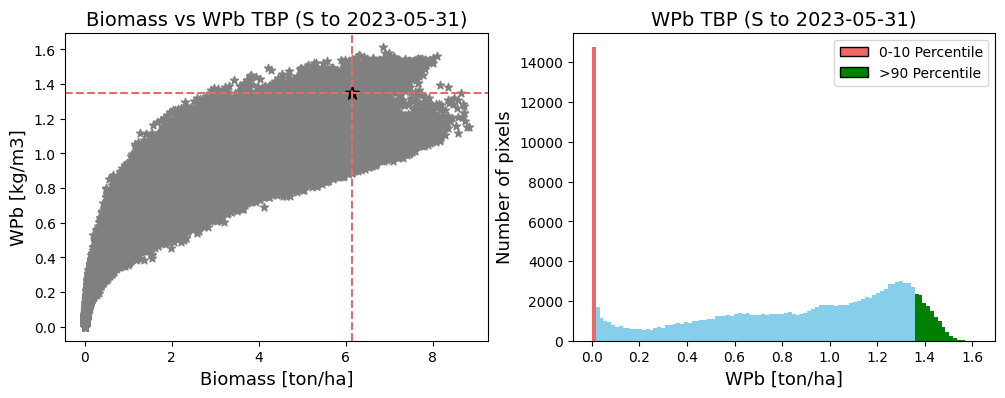

In [16]:
"""
This script processes seasonal data to calculate target biomass and WPb levels.
It reads AGBM, and WPb from raster files, reshapes the data, and computes targets based on a specified percentile.
The season and date range are extracted for labeling, and scatter plots and histograms are generated to visualize biomass and WPb.
Results are saved in a DataFrame.
"""
Season        = []
BiomassTarget = []
WPbTarget     = []

for in_fhAGBM, in_fhWPb in zip(input_AGBMfhs, input_WPbfhs):
    # Open the files with rioxarray
    AGBM_ds = rioxarray.open_rasterio(in_fhAGBM)
    WPb_ds = rioxarray.open_rasterio(in_fhWPb)

    # Convert to numpy arrays
    AGBM = AGBM_ds.values[0]
    WPb = WPb_ds.values[0]

    # Reshape the arrays
    Biomass_1D = AGBM.ravel()
    WPb_1D = WPb.ravel()

    # Targets productivity
    Target_biomass = round(np.nanpercentile(Biomass_1D, TargetPercentile), 0)  # Target productivity yield
    TargetWP = round(np.nanpercentile(WPb_1D, TargetPercentile), 1)            # Target productivity WP

    # Extract season and date range from the filename
    season, date_range = extract_season_and_dates(in_fhAGBM)

    Season.append(season)
    BiomassTarget.append(Target_biomass)
    WPbTarget.append(TargetWP)

    # Scatter plot of Yield vs WP and histogram of WP for the season
    title1 = f'Biomass vs WPb {season} ({date_range})'
    xlable1 = 'Biomass [ton/ha]'
    ylable1 = 'WPb [kg/m3]'

    title2 = f'WPb {season} ({date_range})'
    xlable2 = 'WPb [ton/ha]'
    ylable2 = 'Number of pixels'

    plotProductivityTargets(Biomass_1D, Biomass_1D, WPb_1D, title1, xlable1, ylable1, title2, xlable2, ylable2)

# Save the data into dataframe - tabular form
data_tuples = list(zip(Season, BiomassTarget, WPbTarget))
df_targets = pd.DataFrame(data_tuples, columns=['Season', 'Target_biomass', 'Target_WPb'])

df_targets

## iii) Calculate the target crop yield and target crop water productivity

In [17]:
# Target productivity
TargetPercentile = 90

In [18]:
# Import the relevant input data
dir_proj = os.path.split(os.getcwd())[0]           # Get the current project directory.
dir_data = r"/content/content/output/"           # Define the base directory where the data is stored.

input_Yieldfolder  = os.path.join(dir_proj, dir_data, "yield_season")
input_Yieldfhs     = sorted(glob.glob(input_Yieldfolder + '/*.tif'))

input_WPyfolder   = os.path.join(dir_proj, dir_data, "Cwp_season")
input_WPyfhs      = sorted(glob.glob(input_WPyfolder + '/*.tif'))

,Season,Target_yield,Target_WPy
0,yield,3.0,0.6


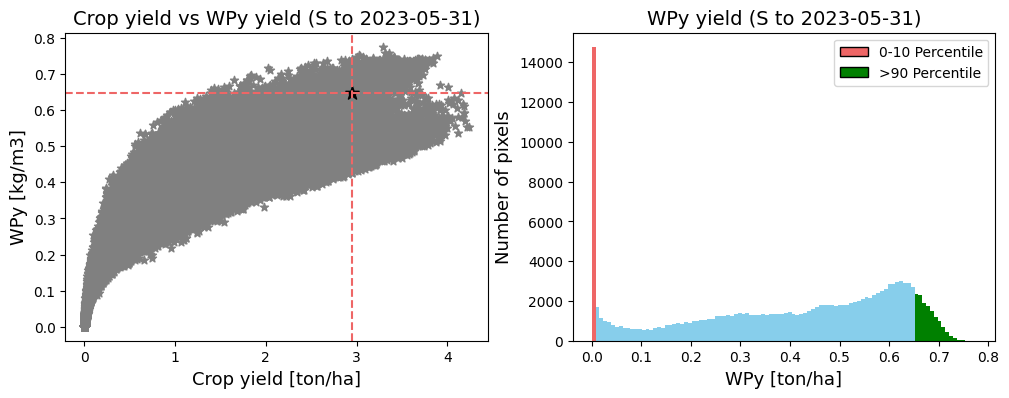

In [20]:
"""
This script processes seasonal data to calculate target crop yield and water productivity (WPy).
It reads yield, and WPy from raster files, reshapes the data, and computes target values based on a specified percentile.
The season and date range are extracted for labeling, and scatter plots and histograms are generated to visualize the relationship between yield and WPy.
Results are stored in a DataFrame for further analysis.
"""
# Read spatial information from the first input file using rioxarray
in_fh = input_Yieldfhs[0]

Season        = []
YieldTarget   = []
WPyTarget     = []

for in_fhYield, in_fhWPy in zip(input_Yieldfhs, input_WPyfhs):
    # Open the files with rioxarray
    Yield_ds = rioxarray.open_rasterio(in_fhYield)
    WPy_ds = rioxarray.open_rasterio(in_fhWPy)

    # Convert to numpy arrays
    Yield = Yield_ds.values[0]
    WPy = WPy_ds.values[0]

    # Reshape the arrays
    Yield_1D = Yield.ravel()
    WPy_1D = WPy.ravel()

    # Targets productivity
    Target_yield = round(np.nanpercentile(Yield_1D, TargetPercentile), 0)  # Yield at 90/95 percentile
    TargetWP = round(np.nanpercentile(WPy_1D, TargetPercentile), 1)       # WP at 90/95 percentile

    # Extract season and date range from the filename
    season, date_range = extract_season_and_dates(in_fhYield)

    Season.append(season)
    YieldTarget.append(Target_yield)
    WPyTarget.append(TargetWP)

    # Scatter plot of Yield vs WP and histogram of WP
    spatial_extent = (Yield_ds.x.min(), Yield_ds.x.max(), Yield_ds.y.min(), Yield_ds.y.max())
    title1 = f'Crop yield vs WPy {season} ({date_range})'
    xlable1 = 'Crop yield [ton/ha]'
    ylable1 = 'WPy [kg/m3]'

    title2 = f'WPy {season} ({date_range})'
    xlable2 = 'WPy [ton/ha]'
    ylable2 = 'Number of pixels'

    plotProductivityTargets(Yield_1D, Yield_1D, WPy_1D, title1, xlable1, ylable1, title2, xlable2, ylable2)

# Save the data into dataframe - tabular form
data_tuples = list(zip(Season, YieldTarget, WPyTarget))
df_targets = pd.DataFrame(data_tuples, columns=['Season', 'Target_yield', 'Target_WPy'])

df_targets


## Step 3 - Identify bright spots (Map the bright spots in the study area)
* The bright spots are idetified based on the target biomass and target biomass water productivity (WPb)

In [21]:
# Target productivity
TargetPercentile = 90

In [22]:
# Import the relevant input data
dir_proj = os.path.split(os.getcwd())[0]           # Get the current project directory.
dir_data = r"/content/content/output/"           # Define the base directory where the data is stored.

input_AGBMfolder  = os.path.join(dir_proj, dir_data, "TBP_season")
input_AGBMfhs     = sorted(glob.glob(input_AGBMfolder + '/*.tif'))

input_WPbfolder   = os.path.join(dir_proj, dir_data, "BWP_season")
input_WPbfhs      = sorted(glob.glob(input_WPbfolder + '/*.tif'))

## Summary of Steps to Process and Visualize bright spots:

This script processes raster data for **Biomass (AGBM)**, and **Biomass Water Productivity (WPb)** for a specified season. The goal is to calculate and visualize target thresholds for Biomass and WPb, as well as highlight areas where both conditions are met. Below is a summary of the steps:

1. **Open Raster Files**: The script opens the Biomass, and WPb raster files using `rioxarray`.
2. **Convert to Numpy Arrays**: Each raster dataset is converted into a 2D NumPy array for further calculations.
3. **Reshape Arrays**: The data is reshaped into 1D arrays to facilitate percentile-based calculations.
4. **Calculate Target Thresholds**: Percentile-based thresholds (e.g., 90th or 95th percentile) are calculated for both Biomass and WPb. Maximum values for each dataset are also computed for visualization.
5. **Extract Season and Date Information**: The season and date range are extracted from the file names for labeling purposes.
6. **Set Spatial Extent for Plotting**: The spatial extent (longitude and latitude) is defined to ensure proper geographic alignment of the plots.
7. **Plot the Data**:
   - **Figure 1**: Plots areas where Biomass is greater than or equal to the target.
   - **Figure 2**: Plots areas where WPb is greater than or equal to the target.
   - **Figure 3**: Plots the intersection, highlighting areas where both Biomass and WPb meet their respective target thresholds.
8. **Calculate and Print Percentages**: For each figure, the script calculates and prints the percentage of the area that meets the target conditions for Biomass, WPb, and their intersection.
9. **Display the Plots**: The script uses subplots to display the three figures side by side for easy comparison, adjusting the layout for better readability.


Percentage of area meeting Biomass target: 12.16%
Percentage of area meeting WPb target: 5.23%
Percentage of area meeting both Biomass and WPb targets: 4.67%


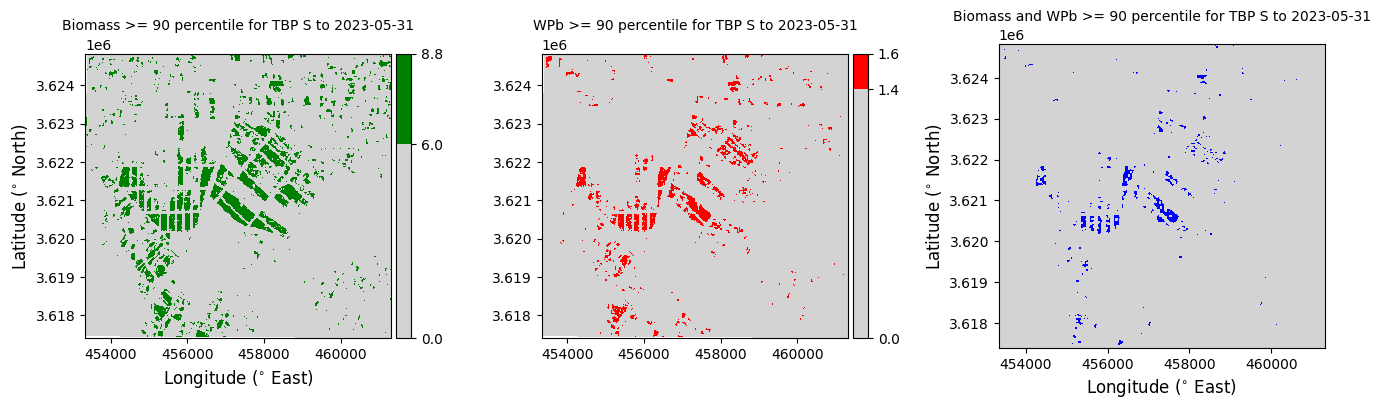

In [24]:
# Process Biomass, and WPb data to calculate and plot targets

for in_fhAGBM, in_fhWPb in zip(input_AGBMfhs, input_WPbfhs):
    # Step 1: Open the files using rioxarray
    AGBM_ds = rioxarray.open_rasterio(in_fhAGBM)
    WPb_ds = rioxarray.open_rasterio(in_fhWPb)

    # Step 2: Convert raster data to numpy arrays
    AGBM = AGBM_ds.values[0]
    WPb = WPb_ds.values[0]

    # Step 3: Reshape arrays into 1D for percentile calculations
    Biomass_1D = AGBM.ravel()
    WPb_1D = WPb.ravel()

    # Step 4: Calculate target thresholds based on specified percentiles
    TargetBiomass = round(np.nanpercentile(Biomass_1D, TargetPercentile), 0)
    TargetWP = round(np.nanpercentile(WPb_1D, TargetPercentile), 1)
    maxBiomass = round(np.nanmax(AGBM), 1)
    maxWPb = round(np.nanmax(WPb), 1)

    # Step 5: Extract season and date range for labeling from the file name
    season, date_range = extract_season_and_dates(in_fhAGBM)

    # Step 6: Prepare for plotting - Define spatial extent
    spatial_extent = (AGBM_ds.x.min(), AGBM_ds.x.max(), AGBM_ds.y.min(), AGBM_ds.y.max())

    # Create subplots for three figures
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

    ### Figure 1: Biomass >= target
    # Calculate the percentage for Biomass >= target
    valid_biomass_pixels = np.count_nonzero(~np.isnan(AGBM))  # Count non-NaN pixels
    target_biomass_pixels = np.count_nonzero(AGBM >= TargetBiomass)  # Count pixels where biomass >= target
    percentage_biomass = (target_biomass_pixels / valid_biomass_pixels) * 100 if valid_biomass_pixels > 0 else 0

    print(f'Percentage of area meeting Biomass target: {percentage_biomass:.2f}%')

    # Plot Biomass >= target
    cmap1 = colors.ListedColormap(['lightgrey', 'green'])
    bounds1 = [0, TargetBiomass, maxBiomass]
    norm1 = colors.BoundaryNorm(bounds1, cmap1.N)

    img1 = ax1.imshow(AGBM, cmap=cmap1, norm=norm1, extent=spatial_extent)
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img1, spacing='proportional', ax=ax1, cax=cax1)
    ax1.set_title(f'Biomass >= {TargetPercentile} percentile for {season} {date_range}', fontsize=10)
    ax1.set_xlabel('Longitude ($^{\circ}$ East)', fontsize=12)
    ax1.set_ylabel('Latitude ($^{\circ}$ North)', fontsize=12)

    ### Figure 2: WPb >= target
    # Calculate the percentage for WPb >= target
    valid_WPb_pixels = np.count_nonzero(~np.isnan(WPb))  # Count non-NaN pixels
    target_WPb_pixels = np.count_nonzero(WPb >= TargetWP)  # Count pixels where WPb >= target
    percentage_WPb = (target_WPb_pixels / valid_WPb_pixels) * 100 if valid_WPb_pixels > 0 else 0

    print(f'Percentage of area meeting WPb target: {percentage_WPb:.2f}%')

    # Plot WPb >= target
    cmap2 = colors.ListedColormap(['lightgrey', 'red'])
    bounds2 = [0, TargetWP, maxWPb]
    norm2 = colors.BoundaryNorm(bounds2, cmap2.N)

    img2 = ax2.imshow(WPb, cmap=cmap2, norm=norm2, extent=spatial_extent)
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img2, spacing='proportional', ax=ax2, cax=cax2)
    ax2.set_title(f'WPb >= {TargetPercentile} percentile for {season} {date_range}', fontsize=10)

    ### Figure 3: Intersection of Biomass and WPb >= target
    # Areas that meet both biomass and WPb targets will be blue, others will be light grey.
    Biomass_WPb_targetSpots = np.where((AGBM >= TargetBiomass) & (WPb >= TargetWP), 1, 0)  # Intersection of biomass and WPb targets

    # Calculate the percentage for Biomass and WPb >= target
    valid_pixels = np.count_nonzero(~np.isnan(Biomass_WPb_targetSpots))  # Count non-NaN pixels
    target_pixels = np.count_nonzero(Biomass_WPb_targetSpots == 1)  # Count pixels meeting both conditions
    percentage_intersection = (target_pixels / valid_pixels) * 100 if valid_pixels > 0 else 0

    print(f'Percentage of area meeting both Biomass and WPb targets: {percentage_intersection:.2f}%')

    # Plot the third figure
    cmap3 = colors.ListedColormap(['lightgrey', 'blue'])
    norm3 = colors.BoundaryNorm([0, 1, 2], cmap3.N)  # Adjust the bounds for lightgrey and blue

    img3 = ax3.imshow(Biomass_WPb_targetSpots, cmap=cmap3, norm=norm3, extent=spatial_extent)
    ax3.set_title(f'Biomass and WPb >= {TargetPercentile} percentile for {season} {date_range}', fontsize=10)
    ax3.set_xlabel('Longitude ($^{\circ}$ East)', fontsize=12)
    ax3.set_ylabel('Latitude ($^{\circ}$ North)', fontsize=12)

    # Adjust layout and display the plots
    plt.subplots_adjust(wspace=0.4)
    plt.show()


## Step 4 - Calculate productivity gaps
* i) Biomass gaps and biomass WP gaps
* ii)Crop yield gaps and crop WP gaps

## i) Biomass gaps and biomass water productivity gaps

In [25]:
# Define target productivity
TargetPercentile = 90

## * Import the input data (biomass and WPb raster data)

In [26]:
# Import relevant data
dir_proj = os.path.split(os.getcwd())[0]           # Get the current project directory.
dir_data = r"/content/content/output/"             # Define the base directory where the data is stored.

input_AGBMfolder  = os.path.join(dir_proj, dir_data, "TBP_season")
input_AGBMfhs     = sorted(glob.glob(input_AGBMfolder + '/*.tif'))

## ** Output folder: Make one or connect to the existing one

In [27]:
# create output_folders

dir_proj = os.path.split(os.getcwd())[0]  # os.getcwd() is for the current directory
dir_data = r"/content/output/"            # update directory

# output_folder
output_folder1 = os.path.join(dir_proj, dir_data, "BiomassGaps")
output_folder2 = os.path.join(dir_proj, dir_data, "WPbgaps")

# if the directory and folder does not exit, make one
if not os.path.exists(output_folder1):
    os.makedirs(output_folder1)
if not os.path.exists(output_folder2):
    os.makedirs(output_folder2)

output_folder1, output_folder2

('/content/output/BiomassGaps', '/content/output/WPbgaps')

## *** Calculate biomass gaps

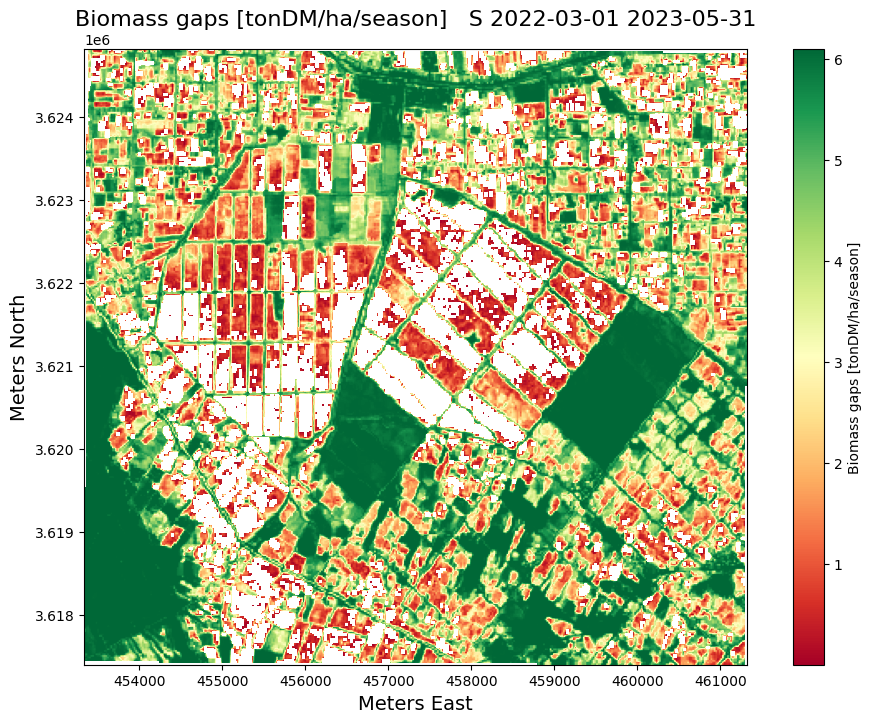

In [29]:

for in_fhAGBM in input_AGBMfhs:
    # Open the AGBM file with rioxarray
    AGBM_ds = rioxarray.open_rasterio(in_fhAGBM)

    # Convert to numpy array
    AGBM = AGBM_ds.values[0]  # assuming the first band is used

    # Productivity targets and productivity gaps
    Biomass_1D = AGBM.ravel()  # Reshape the array to 1D
    TargetBiomass = round(np.nanpercentile(Biomass_1D, TargetPercentile), 1)
    Biomassgap = np.where(AGBM < TargetBiomass, TargetBiomass - AGBM, np.nan)

    # Add an extra dimension to match the expected shape (1, 893, 1061)
    Biomassgap = Biomassgap[np.newaxis, :, :]

    # Identify the date from the file name
    date = os.path.basename(in_fhAGBM).split('.')[0].replace('TBP', '').replace('_', ' ')

    # Check if 'pywapor' is in the file name, and remove it if it exists
    if 'pywapor' in date:
        date = date.replace('pywapor', '')

    # Save yield gap
    output_folder = output_folder1
    basename = os.path.basename(in_fhAGBM).replace('TBP', 'BiomassGaps')
    output_fn = os.path.join(output_folder, basename)

    # Save the Biomass gap as a GeoTIFF using rioxarray
    Biomassgap_ds = AGBM_ds.copy(data=Biomassgap)
    Biomassgap_ds.rio.to_raster(output_fn)

    spatial_extent = (AGBM_ds.x.min(), AGBM_ds.x.max(), AGBM_ds.y.min(), AGBM_ds.y.max())
    # Plot the raster map
    plt.figure(figsize=(12, 8))
    plt.imshow(Biomassgap[0], cmap='RdYlGn', vmin=np.nanmin(Biomassgap), vmax=np.nanmax(Biomassgap), extent=spatial_extent)
    plt.colorbar(shrink=1, label='Biomass gaps [tonDM/ha/season]')
    plt.xlabel('Meters East', fontsize=14)
    plt.ylabel('Meters North', fontsize=14)
    plt.title('Biomass gaps [tonDM/ha/season] ' + date, fontsize=16)
    plt.show()


## **** Biomass WP gaps (WPb gaps)

In [30]:
# Define target productivity
TargetPercentile = 90

In [31]:
# Import relevant data
dir_proj = os.path.split(os.getcwd())[0]           # Get the current project directory.
dir_data = r"/content/content/output/"             # Define the base directory where the data is stored.

input_WPbfolder   = os.path.join(dir_proj, dir_data, "BWP_season")
input_WPbfhs      = sorted(glob.glob(input_WPbfolder + '/*.tif'))

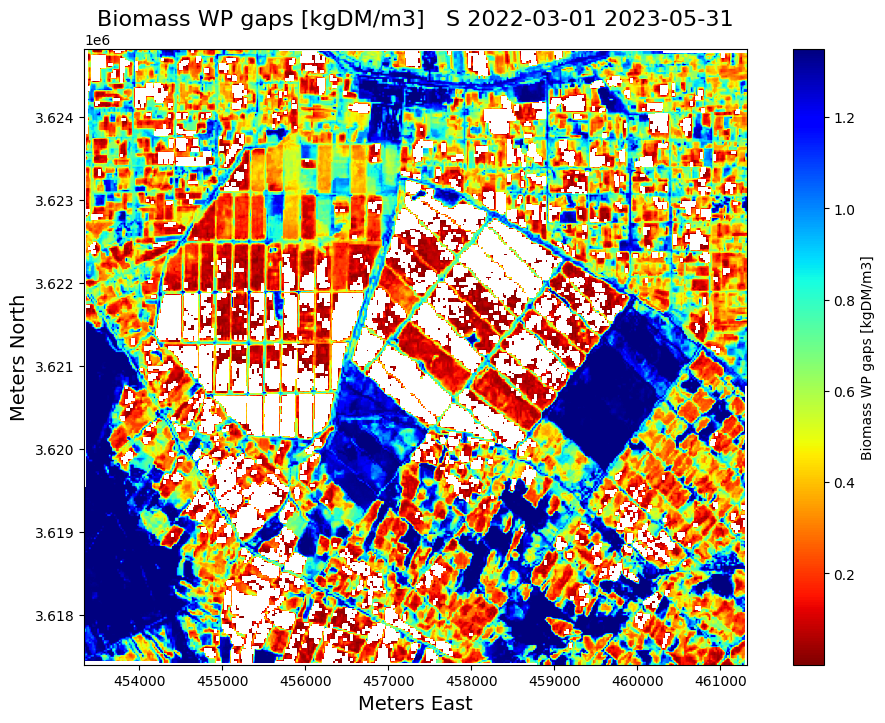

In [32]:

for in_fhWPb in input_WPbfhs:
    # Open the WPb file with rioxarray
    WPb_ds = rioxarray.open_rasterio(in_fhWPb)

    # Convert to numpy array
    WPb = WPb_ds.values[0]  # assuming the first band is used

    # Productivity targets and productivity gaps
    WPb_1D = WPb.ravel()  # Reshape the array to 1D
    TargetWPb = round(np.nanpercentile(WPb_1D, TargetPercentile), 2)
    WPbgap = np.where(WPb < TargetWPb, TargetWPb - WPb, np.nan)

    # Add an extra dimension to match the expected shape (1, ysize, xsize)
    WPbgap = WPbgap[np.newaxis, :, :]

    # Identify the date from the file name
    date = os.path.basename(in_fhWPb).split('.')[0].replace('BWP', '').replace('_', ' ')

    # Check if 'pywapor' is in the file name, and remove it if it exists
    if 'pywapor' in date:
        date = date.replace('pywapor', '')

    # Save yield gap
    output_folder = output_folder2
    basename = os.path.basename(in_fhWPb).replace('BWP', 'WPbGaps')
    output_fn = os.path.join(output_folder, basename)

    # Save the WP gap as a GeoTIFF using rioxarray
    WPbgap_ds = WPb_ds.copy(data=WPbgap)
    WPbgap_ds.rio.to_raster(output_fn)

    spatial_extent = (WPb_ds.x.min(), WPb_ds.x.max(), WPb_ds.y.min(), WPb_ds.y.max())

    # Plot the raster map
    plt.figure(figsize=(12, 8))
    plt.imshow(WPbgap[0], cmap='jet_r', vmin=np.nanmin(WPbgap), vmax=np.nanmax(WPbgap), extent=spatial_extent)
    plt.colorbar(shrink=1, label='Biomass WP gaps [kgDM/m3]')
    plt.xlabel('Meters East', fontsize=14)
    plt.ylabel('Meters North', fontsize=14)
    plt.title('Biomass WP gaps [kgDM/m3] ' + date, fontsize=16)
    plt.show()


## ii) Crop yield gaps and crop water productivity gaps

In [33]:
# Target productivity
TargetPercentile = 90

## * Import the input data (yield and WPy raster data)

In [34]:
# Import relevant data
dir_proj = os.path.split(os.getcwd())[0]           # Get the current project directory.
dir_data = r"/content/content/output/"             # Define the base directory where the data is stored.

input_Yieldfolder  = os.path.join(dir_proj, dir_data, "yield_season")
input_Yieldfhs     = sorted(glob.glob(input_Yieldfolder + '/*.tif'))

input_WPyfolder   = os.path.join(dir_proj, dir_data, "Cwp_season")
input_WPyfhs      = sorted(glob.glob(input_WPyfolder + '/*.tif'))

## ** Output folder: Make one or connect to the existing one

In [35]:
# create output_folders

dir_proj = os.path.split(os.getcwd())[0]
dir_data = r"/content/output/"

output_folder1 = os.path.join(dir_proj, dir_data, "YieldGaps")
output_folder2 = os.path.join(dir_proj, dir_data, "WPygaps")

# if the directory and folder does not exit, make one
if not os.path.exists(output_folder1):
    os.makedirs(output_folder1)
if not os.path.exists(output_folder2):
    os.makedirs(output_folder2)

output_folder1, output_folder2

('/content/output/YieldGaps', '/content/output/WPygaps')

## ** Crop yield gaps

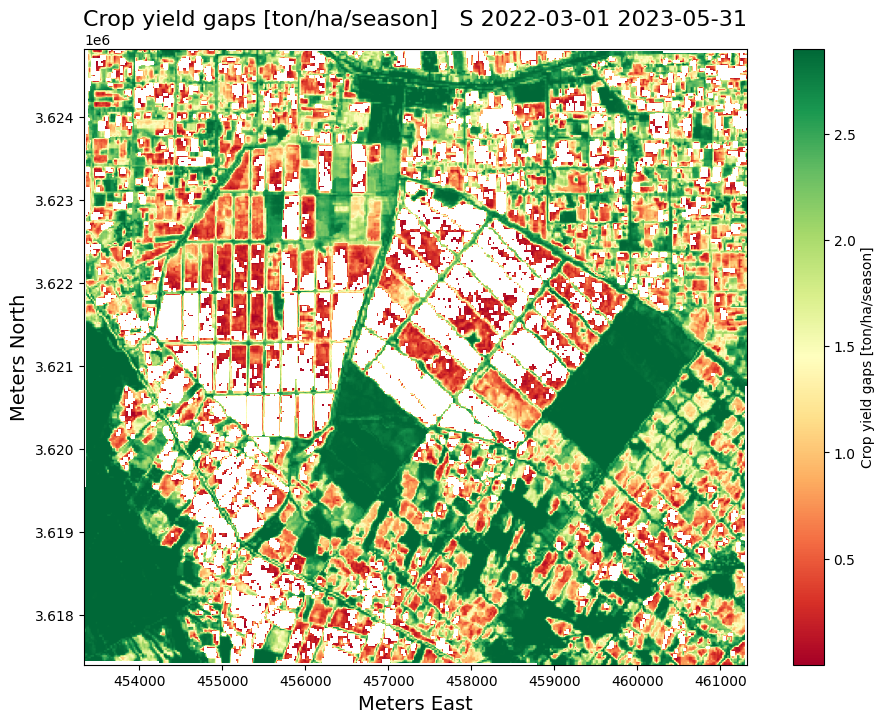

In [36]:
import rioxarray
import numpy as np
import os
import matplotlib.pyplot as plt

for in_fhYield in input_Yieldfhs:
    # Open the Yield file with rioxarray
    Yield_ds = rioxarray.open_rasterio(in_fhYield)

    # Convert to numpy array
    Yield = Yield_ds.values[0]  # assuming the first band is used

    # Productivity targets and productivity gaps
    Yield_1D = Yield.ravel()  # Reshape the array to 1D
    TargetYield = round(np.nanpercentile(Yield_1D, TargetPercentile), 1)
    Yieldgap = np.where(Yield < TargetYield, TargetYield - Yield, np.nan)

    # Add an extra dimension to match the expected shape (1, ysize, xsize)
    Yieldgap = Yieldgap[np.newaxis, :, :]

    # Identify the date from the file name
    date = os.path.basename(in_fhYield).split('.')[0].replace('yield', '').replace('_', ' ')

    # Check if 'pywapor' is in the file name, and remove it if it exists
    if 'pywapor' in date:
        date = date.replace('pywapor', '')

    # Save yield gap
    output_folder = output_folder1
    basename = os.path.basename(in_fhYield).replace('yield', 'YieldGaps')
    output_fn = os.path.join(output_folder, basename)

    # Save the Yield gap as a GeoTIFF using rioxarray
    Yieldgap_ds = Yield_ds.copy(data=Yieldgap)
    Yieldgap_ds.rio.to_raster(output_fn)

    spatial_extent = (Yield_ds.x.min(), Yield_ds.x.max(), Yield_ds.y.min(), Yield_ds.y.max())

    # Plot the raster map
    plt.figure(figsize=(12, 8))
    plt.imshow(Yieldgap[0], cmap='RdYlGn', vmin=np.nanmin(Yieldgap), vmax=np.nanmax(Yieldgap), extent=spatial_extent)
    plt.colorbar(shrink=1, label='Crop yield gaps [ton/ha/season]')
    plt.xlabel('Meters East', fontsize=14)
    plt.ylabel('Meters North', fontsize=14)
    plt.title('Crop yield gaps [ton/ha/season] ' + date, fontsize=16)
    plt.show()


## *** Crop WP gaps

In [37]:
# Define target productivity
TargetPercentile = 90

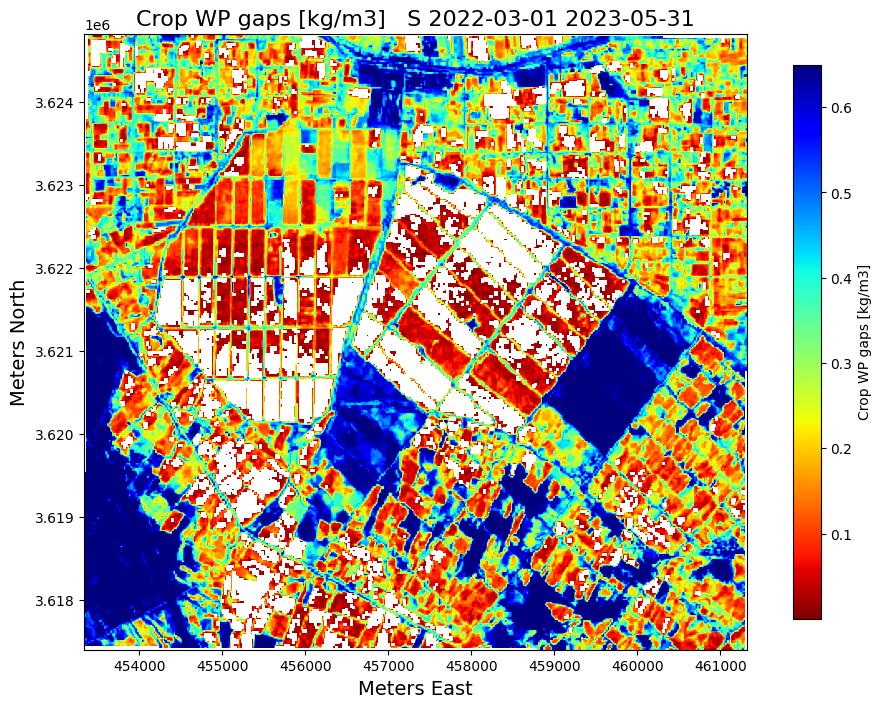

In [38]:

# Read spatial information from the first input file using rioxarray
in_fh = input_WPyfhs[0]

for in_fhWPy in input_WPyfhs:
    # Open the WPy file with rioxarray
    WPy_ds = rioxarray.open_rasterio(in_fhWPy)

    # Convert to numpy array
    WPy = WPy_ds.values[0]  # assuming the first band is used

    # Productivity targets and productivity gaps
    WPy_1D = WPy.ravel()  # Reshape the array to 1D
    TargetWPy = round(np.nanpercentile(WPy_1D, TargetPercentile), 2)
    WPygap = np.where(WPy < TargetWPy, TargetWPy - WPy, np.nan)

    # Add an extra dimension to match the expected shape (1, ysize, xsize)
    WPygap = WPygap[np.newaxis, :, :]

    # Identify the date from the file name
    date = os.path.basename(in_fhWPy).split('.')[0].replace('cWP', '').replace('_', ' ')

    # Check if 'pywapor' is in the file name, and remove it if it exists
    if 'pywapor' in date:
        date = date.replace('pywapor', '')

    # Save yield gap
    output_folder = output_folder2
    basename = os.path.basename(in_fhWPy).replace('cWP', 'WPyGaps')
    output_fn = os.path.join(output_folder, basename)

    # Save the WPy gap as a GeoTIFF using rioxarray
    WPygap_ds = WPy_ds.copy(data=WPygap)
    WPygap_ds.rio.to_raster(output_fn)

    spatial_extent = (WPy_ds.x.min(), WPy_ds.x.max(), WPy_ds.y.min(), WPy_ds.y.max())

    # Plot the raster map
    plt.figure(figsize=(12, 8))
    plt.imshow(WPygap[0], cmap='jet_r', vmin=np.nanmin(WPygap), vmax=np.nanmax(WPygap), extent=spatial_extent)
    plt.colorbar(shrink=0.9, label='Crop WP gaps [kg/m3]')
    plt.xlabel('Meters East', fontsize=14)
    plt.ylabel('Meters North', fontsize=14)
    plt.title('Crop WP gaps [kg/m3] ' + date, fontsize=16)
    plt.show()


## Download file

In [40]:
# 1) Compress the specified folders into a single zip file
!zip -r /content/ProductivityGaps.zip /content/output/

# 2) Download the zipped file from Colab to your local machine
from google.colab import files
files.download(r'/content/ProductivityGaps.zip')

  adding: content/output/ (stored 0%)
  adding: content/output/BiomassGaps/ (stored 0%)
  adding: content/output/BiomassGaps/pywapor_BiomassGaps_S_2022-03-01_2023-05-31.tif (deflated 38%)
  adding: content/output/WPygaps/ (stored 0%)
  adding: content/output/WPygaps/pywapor_WPyGaps_S_2022-03-01_2023-05-31.tif (deflated 31%)
  adding: content/output/YieldGaps/ (stored 0%)
  adding: content/output/YieldGaps/pywapor_YieldGaps_S_2022-03-01_2023-05-31.tif (deflated 37%)
  adding: content/output/WPbgaps/ (stored 0%)
  adding: content/output/WPbgaps/pywapor_WPbGaps_S_2022-03-01_2023-05-31.tif (deflated 32%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>